In [1]:
import xarray as xr
from rasterio.warp import reproject, Resampling
landcover = xr.open_mfdataset("/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/landcover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-*-v2.0.7cds.nc")["lccs_class"]

# IGBP data: from NetCDF to Zarr

The IGBP/landcover dataset is provided as netcdf. We need to reproject it. It is global.

In [2]:
year = 2015

In [3]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
IGBP_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/igbp/landcover10km_global.nc'
)
OUT_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/igbp/landcover_snellius.zarr'
)

In [4]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year}global/era5land/era5land.zarr'
)

In [5]:
ds = xr.open_zarr(ERA5_PATH)

In [6]:
ds = ds.rio.write_crs('WGS84')
target = ds['sp'].isel(time=0, drop=True)

In [7]:
landcover = landcover.rio.write_crs('WGS84')
landcover = landcover.rename(
    lon='longitude',
    lat='latitude',
)
landcover = landcover.assign_coords(
    longitude=(landcover.longitude + 360) % 360,
    latitude=landcover.latitude
)
# roll array to reorder coordinates 
nroll = (landcover.longitude.values >= 180 ).sum()
landcover = landcover.roll(longitude=-nroll, roll_coords=True)

In [13]:
landcover = landcover.rio.write_crs('EPSG:4326')
landcover.rio.write_nodata(landcover.rio.nodata, inplace=True)
landcover_reprojected = landcover.rio.reproject_match(target, resampling=Resampling.mode)
landcover_reprojected = landcover_reprojected.assign_coords({
    "x": landcover_reprojected.x,
    "y": landcover_reprojected.y,
})
# fix naming of coordinates
landcover_reprojected = landcover_reprojected.rename(
    x='longitude',
    y='latitude'
)
print(landcover_reprojected)

<xarray.DataArray 'lccs_class' (time: 1, latitude: 1801, longitude: 3600)>
array([[[210, 210, 210, ..., 210, 210, 210],
        [210, 210, 210, ..., 210, 210, 210],
        [210, 210, 210, ..., 210, 210, 210],
        ...,
        [220, 220, 220, ..., 220, 220, 220],
        [220, 220, 220, ..., 220, 220, 220],
        [220, 220, 220, ..., 220, 220, 220]]], dtype=uint8)
Coordinates:
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 2013-01-01
    spatial_ref  int64 0
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rain

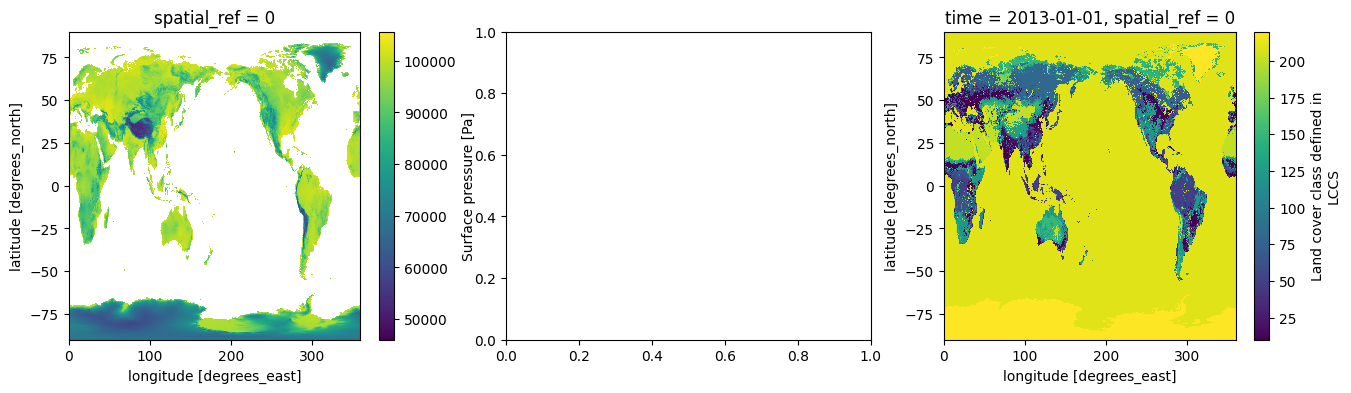

In [20]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

target.plot(ax=axes[0])
# landcover.sel(longitude=slice(20,25), latitude=slice(65, 60)).plot(ax=axes[1])
landcover_reprojected.plot(ax=axes[2])
plt.draw()

In [19]:
landcover_reprojected

<xarray.DataArray 'lccs_class' (time: 1, latitude: 1801, longitude: 3600)>
array([[[210, 210, 210, ..., 210, 210, 210],
        [210, 210, 210, ..., 210, 210, 210],
        [210, 210, 210, ..., 210, 210, 210],
        ...,
        [220, 220, 220, ..., 220, 220, 220],
        [220, 220, 220, ..., 220, 220, 220],
        [220, 220, 220, ..., 220, 220, 220]]], dtype=uint8)
Coordinates:
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 2013-01-01
    spatial_ref  int64 0
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0  10  11  12  20  30  40  50  60  61  62  70  7...
    _FillValue:           255

In [21]:
landcover_reprojected = landcover_reprojected.to_dataset(name='lccs_class').squeeze('time')

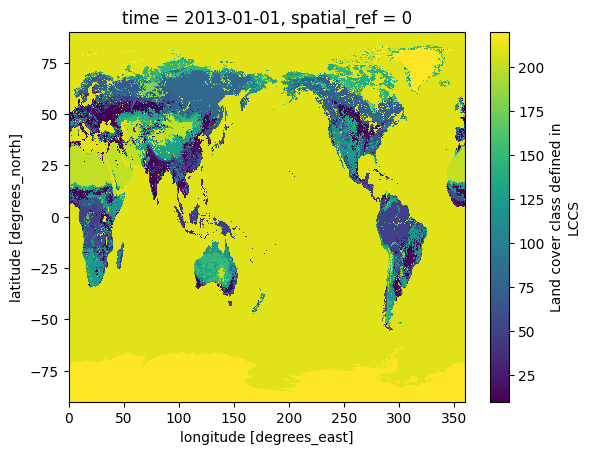

In [23]:
landcover_reprojected.lccs_class.plot()

In [24]:
landcover_reprojected = landcover_reprojected.chunk(
    longitude=250, 
    latitude=250
)
landcover_reprojected.to_zarr(OUT_PATH, mode='w')

In [25]:
landcover_reprojected.lccs_class.mean().compute()

<xarray.DataArray 'lccs_class' ()>
array(186.8132209)
Coordinates:
    time         datetime64[ns] 2013-01-01
    spatial_ref  int64 0

In [12]:
xr.open_zarr(OUT_PATH).lccs_class

<xarray.DataArray 'lccs_class' (latitude: 1801, longitude: 3600)>
dask.array<open_dataset-78c11b756a059ca20e39fb33c47bcd79lccs_class, shape=(1801, 3600), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    time       datetime64[ns] ...
Attributes:
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71,...
    grid_mapping:         spatial_ref
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    valid_max:            220
    valid_min:            1

In [11]:
OUT_PATH1 = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/igbp/landcover.zarr'
)
xr.open_zarr(OUT_PATH1).lccs_class

<xarray.DataArray 'lccs_class' (latitude: 1801, longitude: 3600)>
dask.array<open_dataset-096e4c69667466c357b024970e7c23f3lccs_class, shape=(1801, 3600), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    time       datetime64[ns] ...
Attributes:
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71,...
    grid_mapping:         spatial_ref
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    valid_max:            220
    valid_min:            1